<a href="https://colab.research.google.com/github/MarieHabanova/ZP/blob/main/Klasifikace_emoc%C3%AD_v_textu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finální projekt - Klasifikace emocí v **textu**

## **DSCZ4083 - Data Science**

Tento notebook obsahuje kompletní řešení pro klasifikaci emocí v textových datech z Twitteru.

# Nastavení prostředí a import **knihoven**

In [ ]:
%matplotlib inline
from IPython import get_ipython
from IPython.display import display
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


#  Načteme data z kagglu -> výsledek bude dataframe




In [ ]:
# Stáhnutí z Kaggle
path = kagglehub.dataset_download("nelgiriyewithana/emotions")
df = pd.read_csv(path + '/text.csv').rename(columns = {"Unnamed: 0": "id"})
df.head()

,id,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df = df.drop("id", axis=1)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### Explorace dat

In [ ]:
# Přejmenování sloupců
df = df.rename(columns={"Unnamed: 0": "id"})
print("\nSloupce:", df.columns.tolist())

# Zobrazení prvních řádků
print("\nPrvních 5 řádků:")
df.head()


Sloupce: ['text', 'label']

Prvních 5 řádků:


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
df.isnull().sum()

,0
text,0
label,0


In [ ]:
label_to_emotion = {
    0: "smutek",
    1: "radost",
    2: "hněv",
    3: "strach",
    4: "odpor",
    5: "překvapení"
}
df["emotion"] = df["label"].map(label_to_emotion)
df.head()

,text,label,emotion
0,i just feel really helpless and heavy hearted,4,odpor
1,ive enjoyed being able to slouch about relax a...,0,smutek
2,i gave up my internship with the dmrg and am f...,4,odpor
3,i dont know i feel so lost,0,smutek
4,i am a kindergarten teacher and i am thoroughl...,4,odpor


In [ ]:
n_classes = df['label'].nunique()
n_classes

6

=== DISTRIBUCE EMOCÍ ===
emotion
radost        141067
smutek        121187
strach         57317
odpor          47712
hněv           34554
překvapení     14972
Name: count, dtype: int64

Počet unikátních emocí: 6


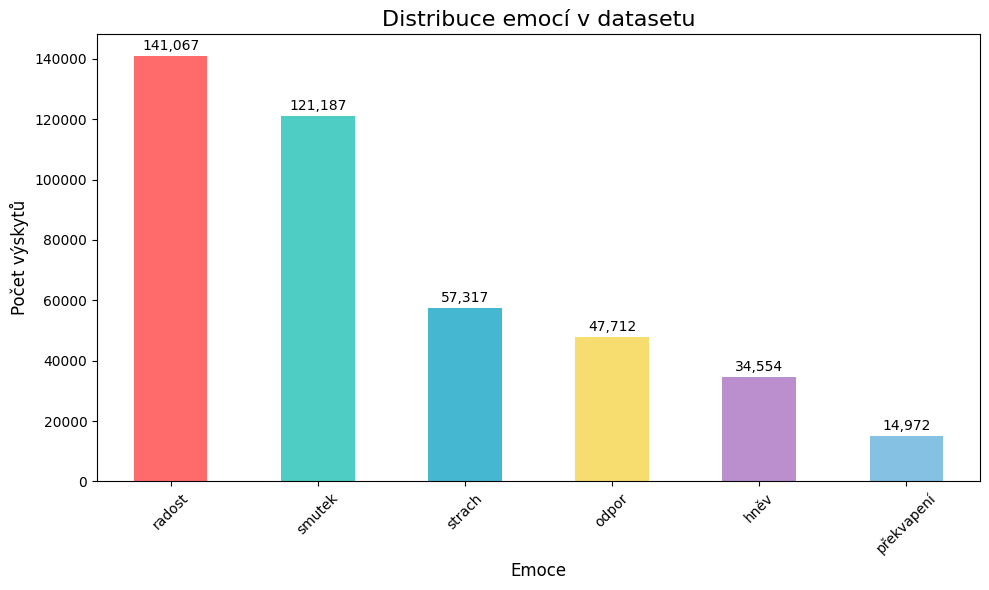

In [ ]:
# Distribuce emocí
print("=== DISTRIBUCE EMOCÍ ===")
emotion_counts = df['emotion'].value_counts() # spočítá kolik výskytů má každá emoce
print(emotion_counts)
print(f"\nPočet unikátních emocí: {df['label'].nunique()}")

# Vizualizace distribuce
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#F7DC6F', '#BB8FCE', '#85C1E2'])
plt.title('Distribuce emocí v datasetu', fontsize=16)
plt.xlabel('Emoce', fontsize=12)
plt.ylabel('Počet výskytů', fontsize=12)
plt.xticks(rotation=45)

# Přidání hodnot na sloupce
for i, v in enumerate(emotion_counts.values):
    plt.text(i, v + 1000, f'{v:,}', ha='center', va='bottom') #Tento řádek ti přidává čísla nad sloupce v grafu

plt.tight_layout()
plt.show()

=== STATISTIKY DÉLKY TEXTŮ ===
         text_length     word_count
count  416809.000000  416809.000000
mean       97.028397      19.211015
std        56.198232      11.051049
min         2.000000       1.000000
25%        54.000000      11.000000
50%        86.000000      17.000000
75%       128.000000      25.000000
max       830.000000     178.000000


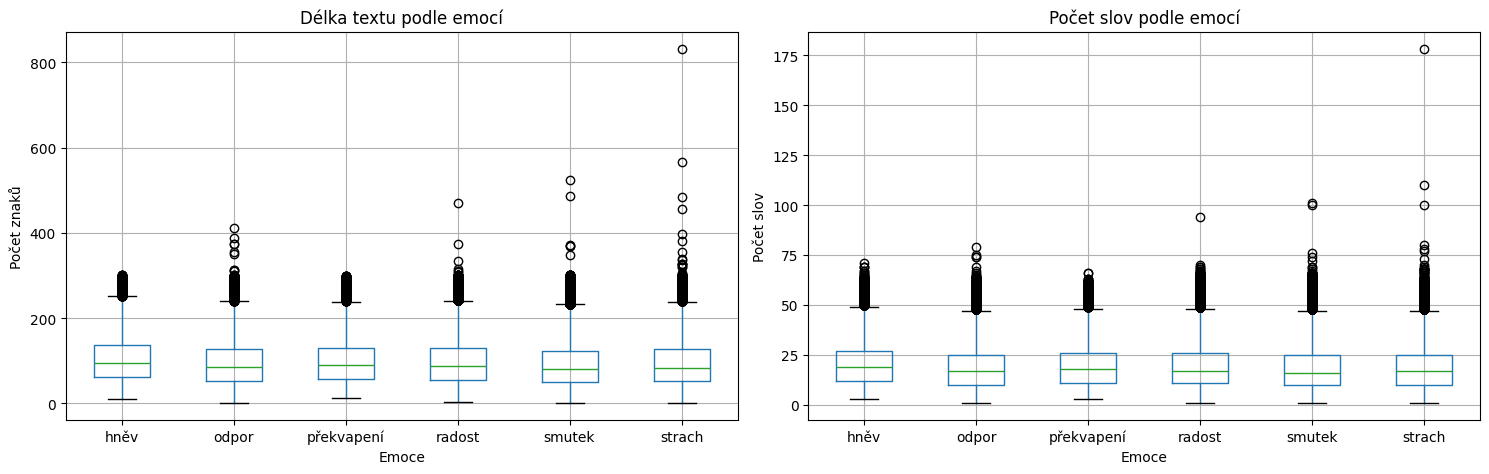

In [ ]:
# Analýza délky textů
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("=== STATISTIKY DÉLKY TEXTŮ ===")
print(df[['text_length', 'word_count']].describe())

# Vizualizace délky textů podle emocí
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # vykreslit dva samostatné grafy vedle sebe

# Box plot pro délku textu
df.boxplot(column='text_length', by='emotion', ax=axes[0])
axes[0].set_title('Délka textu podle emocí')
axes[0].set_xlabel('Emoce')
axes[0].set_ylabel('Počet znaků')

# Box plot pro počet slov
df.boxplot(column='word_count', by='emotion', ax=axes[1])
axes[1].set_title('Počet slov podle emocí')
axes[1].set_xlabel('Emoce')
axes[1].set_ylabel('Počet slov')

plt.suptitle('')
plt.tight_layout()
plt.show()

# Předzpracování textu

In [ ]:
def clean_text(text):
    """Základní čištění textu"""
    # Převod na malá písmena
    text = text.lower()

    # Odstranění URL
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Odstranění emailů
    text = re.sub(r'\S+@\S+', '', text)

    # Odstranění @mentions a #hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Odstranění speciálních znaků a číslic
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Odstranění extra mezer
    text = ' '.join(text.split())

    return text



In [ ]:
df['text'] = df['text'].apply(clean_text)

**Neuronová síť pro klasifikaci textu**

In [ ]:
REDUCE_DATASET = False
if REDUCE_DATASET:
  data = data.sample(5000)

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)
y = to_categorical(df['label'], num_classes=num_classes)
y

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'].fillna(""))
sequences = tokenizer.texts_to_sequences(df['text'].fillna(""))
X = pad_sequences(sequences, maxlen=50, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(333447, 50) (333447, 6)
(83362, 50) (83362, 6)


In [ ]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=50),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
model.save_weights('best_emotion_model.weights.h5')

Epoch 1/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 253s 48ms/step - accuracy: 0.3740 - loss: 1.4776 - val_accuracy: 0.9159 - val_loss: 0.1878
Epoch 2/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 256s 47ms/step - accuracy: 0.9267 - loss: 0.1535 - val_accuracy: 0.9341 - val_loss: 0.1105
Epoch 3/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 262s 47ms/step - accuracy: 0.9365 - loss: 0.1063 - val_accuracy: 0.9364 - val_loss: 0.1058
Epoch 4/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 266s 48ms/step - accuracy: 0.9394 - loss: 0.0971 - val_accuracy: 0.9371 - val_loss: 0.0980
Epoch 5/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 244s 47ms/step - accuracy: 0.9404 - loss: 0.0916 - val_accuracy: 0.9365 - val_loss: 0.0977
Epoch 6/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 244s 47ms/step - accuracy: 0.9416 - loss: 0.0900 - val_accuracy: 0.9386 - val_loss: 0.0984
Epoch 7/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 246s 47ms/step - accuracy: 0.9429 - loss: 0.0863 - val_accuracy: 0.9367 - val_loss: 0.1008
Epoch 8/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 276s 50ms/step - accuracy: 

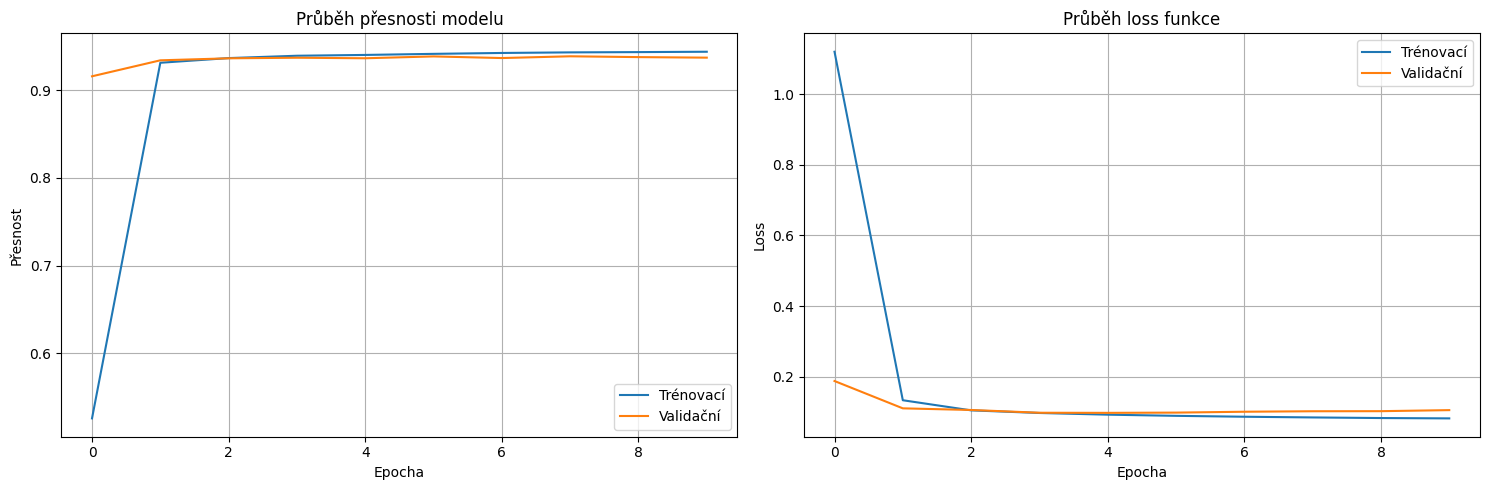


LSTM Test Accuracy: 0.9372


In [ ]:
# Vizualizace průběhu trénování
model.load_weights('best_emotion_model.weights.h5')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Trénovací')
axes[0].plot(history.history['val_accuracy'], label='Validační')
axes[0].set_title('Průběh přesnosti modelu')
axes[0].set_xlabel('Epocha')
axes[0].set_ylabel('Přesnost')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Trénovací')
axes[1].plot(history.history['val_loss'], label='Validační')
axes[1].set_title('Průběh loss funkce')
axes[1].set_xlabel('Epocha')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Vyhodnocení na testovacích datech
lstm_loss, lstm_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")

**Predikce na testovacích datech pomocí trénovaného modelu:**

In [ ]:
y_pred = model.predict(X_test)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step


**Clasifikation report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_test_labels = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)

print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_to_emotion.values()))

Classification Report:
               precision    recall  f1-score   support

      smutek       0.98      0.97      0.97     24238
      radost       0.93      0.99      0.96     28214
        hněv       0.99      0.70      0.82      6911
      strach       0.93      0.95      0.94     11463
       odpor       0.94      0.86      0.90      9542
  překvapení       0.73      0.98      0.84      2994

    accuracy                           0.94     83362
   macro avg       0.92      0.91      0.90     83362
weighted avg       0.94      0.94      0.94     83362



**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert one-hot encoded y_test to single class labels
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities y_pred to single class labels
y_pred_labels = np.argmax(y_pred, axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

Confusion Matrix:
 [[23514    42     6   205   453    18]
 [   31 27839    30    55    11   248]
 [    2  2075  4829     4     1     0]
 [  496    50     2 10855    58     2]
 [   35    23     0   526  8168   790]
 [   22    42     0     2     7  2921]]


**Chybné predikce ze srovnání reálných a predikovaných tříd**

In [ ]:
import random

# chybné predikce ze srovnání reálných a predikovaných tříd
srovnani = pd.DataFrame({'y_test': y_test_labels, 'y_pred': y_pred_labels}) # Vytvoří DataFrame se dvěma sloupci: skutečné (y_test) a predikované (y_pred) třídy.
srovnani["rozdil"] = srovnani["y_test"] != srovnani["y_pred"] # Přidá nový sloupec, kde je True, pokud model predikoval špatně.
chyby_indexy = srovnani[srovnani["rozdil"]].index # Vyfiltruje indexy všech chybných predikcí – tedy pozice, kde se model spletl.

print("Examples of incorrect predictions:")
# Tímto řádkem jednoduše převádíš Pandas indexy chyb (z chyby_indexy) na běžný Python seznam:
incorrect_indices = chyby_indexy.tolist()

sampled_indices = random.sample(incorrect_indices, min(5, len(incorrect_indices)))

for index in sampled_indices:
    print(f"Index v testovacím setu: {index}")
    print(f"Skutečná emoce: {label_to_emotion[srovnani.loc[index, 'y_test']]}")
    print(f"Předpovězená emoce: {label_to_emotion[srovnani.loc[index, 'y_pred']]}")
    print("-" * 20)



Examples of incorrect predictions:
Index v testovacím setu: 38704
Skutečná emoce: radost
Předpovězená emoce: překvapení
--------------------
Index v testovacím setu: 40609
Skutečná emoce: odpor
Předpovězená emoce: strach
--------------------
Index v testovacím setu: 71550
Skutečná emoce: hněv
Předpovězená emoce: radost
--------------------
Index v testovacím setu: 3653
Skutečná emoce: radost
Předpovězená emoce: překvapení
--------------------
Index v testovacím setu: 21748
Skutečná emoce: hněv
Předpovězená emoce: radost
--------------------


**ULožení trénovaného model (včetně architektury, vah a optimalizátoru) do souboru .keras**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/best_emotion_model.keras"

# Save model and tokenizer
model.save(output_dir)

ukládáš celý trénovaný model (včetně architektury, vah a optimalizátoru) do souboru .keras, který je vhodný pro pozdější načtení pomocí: from tensorflow.keras.models import load_model model = load_model(output_dir)